In [1]:
#Find RT entropy for unperturbed BTZ in global coords

In [44]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
from xnp import *
backend = 'cupy' if getattr(np, '__name__', '') == 'cupy' else 'numpy'

In [45]:
#let's try sympy?
#rp, r, r0, R, l = smp.symbols("r' r r_0 R l")
rp = smp.Symbol("r'",real=True)
r = smp.Symbol("r",real=True,positive=True)
r0 = smp.Symbol("r_0",real=True,positive=True)
R = smp.Symbol("R",real=True,positive=True)
l = smp.Symbol(r"\mathcal{l}",real=True)
t = smp.Symbol('t',real=True)
f_expr = l**2 / (r**2 - R**2)
f = smp.Lambda(r,f_expr)

In [46]:
f(r0)

           2
\mathcal{l} 
────────────
    2     2 
 - R  + r₀  

In [47]:
rpSolns = smp.solvers.solve(rp**4*(1-f(r))**2*f(r)*f(r0) + 2*f(r0)*(1-f(r))*rp**2 + f(r0)/f(r) + f(r)**2*rp**2 - 1,rp)
rpSolns

⎡        _____________________________________________________________________ ↪
⎢       ╱                                                                      ↪
⎢      ╱                                                             6         ↪
⎢     ╱                                                           2⋅R          ↪
⎢-   ╱    ──────────────────────────────────────────────────────────────────── ↪
⎢   ╱        4            2      2            4      2            2  2         ↪
⎣ ╲╱      2⋅R ⋅\mathcal{l}  + 4⋅R ⋅\mathcal{l}  - 4⋅R ⋅\mathcal{l} ⋅r  + 2⋅\ma ↪

↪ ____________________________________________________________________________ ↪
↪                                                                              ↪
↪                                                                              ↪
↪                                                                              ↪
↪ ───────────────────────────────────────────────── + ──────────────────────── ↪
↪         6                

In [48]:
#now its time to check validity, want only the solutions with negative r' as we fall into the black hole

In [49]:
Nsoln1 = smp.lambdify((r,r0,R,l),rpSolns[0],modules=[backend])
Nsoln2 = smp.lambdify((r,r0,R,l),rpSolns[2],modules=[backend])

In [74]:
Nsoln1(np.array([0.000001,0.99,1,2,3,4,4.99999]),10,1,1)

array([-1.0052517 , -0.0199    , -0.        , -2.67708965, -4.25394466,
       -4.80054903, -4.97159851])

In [75]:
Nsoln2(np.array([0.000001,0.99,1,2,3,4,4.99999]),10,1,1)

array([-4.97387867, -1.37635407, -0.        ,         nan,         nan,
               nan,         nan])

In [71]:
#soln1 is valid for all space, while soln2 is only valid in the event horizon
#so let's try three different cases: integrate action from EH to r0, integrate from 0 to r0 using only soln1, and then the same using a piecewise r'
#we'll try these symbolically and then numerically with variable r0

In [7]:
rp1 = rpSolns[0]
rp1

        ______________________________________________________________________ ↪
       ╱                                                                       ↪
      ╱                                                             6          ↪
     ╱                                                           2⋅R           ↪
-   ╱    ───────────────────────────────────────────────────────────────────── ↪
   ╱        4            2      2            4      2            2  2          ↪
 ╲╱      2⋅R ⋅\mathcal{l}  + 4⋅R ⋅\mathcal{l}  - 4⋅R ⋅\mathcal{l} ⋅r  + 2⋅\mat ↪

↪ ____________________________________________________________________________ ↪
↪                                                                              ↪
↪                                                                              ↪
↪                                                                              ↪
↪ ──────────────────────────────────────────────── + ───────────────────────── ↪
↪        6                4

In [8]:
integrandExpr1 = smp.sqrt(f(r)*rp1**2 + 1/f(r))/rp1
integrand1 = smp.Lambda(r,integrandExpr1)

In [10]:
integrandExpr1

           ___________________________________________________________________ ↪
          ╱              ⎛                                                     ↪
         ╱               ⎜                                                     ↪
        ╱              2 ⎜                                                     ↪
       ╱    \mathcal{l} ⋅⎜──────────────────────────────────────────────────── ↪
      ╱                  ⎜   4            2      2            4      2         ↪
     ╱                   ⎝2⋅R ⋅\mathcal{l}  + 4⋅R ⋅\mathcal{l}  - 4⋅R ⋅\mathca ↪
-   ╱       ────────────────────────────────────────────────────────────────── ↪
   ╱                                                                           ↪
 ╲╱                                                                            ↪
────────────────────────────────────────────────────────────────────────────── ↪
                        ______________________________________________________ ↪
                       ╱    

In [ ]:
smp.integrate(integrand1(r),(r,R,r0))

In [ ]:
#welp i guess i expected that it wouldnt go well symbolically, time to numerically integrate this guy
#lets iterate over R and set l=1 r0=1000000

In [14]:
Nintegrand1 = smp.lambdify((r,r0,R,l),integrandExpr1,modules=[backend])

In [ ]:
#integrate from origin to boundary 
def action1(r0,l,N,rMin=0.001):
    RGrid_full = np.logspace(np.log10(rMin), np.log10(r0-1), N)
    valid_mask = 1.5 * RGrid_full < r0
    RGrid = RGrid_full[valid_mask]
    t = np.linspace(0,1,N)
    rGrid = t[:-1,None] * (r0 - 1.1*RGrid[None,:]) + 1.1*RGrid[None,:]
    rGrid = rGrid[:,:-1]
    vals = Nintegrand1(rGrid, r0, RGrid[None, :-1], l)
    action = np.trapz(vals,rGrid,axis=0)
    return np.array(RGrid), np.array(action)

In [ ]:
def action1Alt(R, l, N, r0_lo=1e-2, r0_hi=1e6, M=None, band=0.0):
    # r0 grid (N columns)
    r0Grid = np.logspace(np.log10(r0_lo), np.log10(r0_hi), N)
    # radial samples (M rows), use midpoints to avoid endpoints 0 and r0
    if M is None:
        M = max(256, N)
    t = (np.arange(M) + 0.5) / M  # (0,1)
    rGrid = t[:, None] * r0Grid[None, :]  # (M, N)

    # Evaluate integrand
    vals = Nintegrand1(rGrid, r0Grid[None, :], R, l)

    # Keep real part if tiny imaginary noise appears
    if np.iscomplexobj(vals):
        vals = vals.real

    # Mask a small band around r = R to avoid the pole
    if band and band > 0:
        mask = np.abs(rGrid - R) < band * (abs(R) if abs(R) > 0 else 1.0)
        vals = np.where(mask, np.nan, vals)

    # Integrate each column while ignoring NaNs
    # (trapz returns NaN if any NaN present, so filter per column)
    S = np.empty(N, dtype=float if getattr(np, "__name__", "") == "numpy" else np.float64)
    for j in range(N):
        col_mask = np.isfinite(vals[:, j]) & np.isfinite(rGrid[:, j])
        if col_mask.sum() >= 2:
            S[j] = np.trapz(vals[col_mask, j], rGrid[col_mask, j])
        else:
            S[j] = np.nan

    return r0Grid.get(), S.get()

In [52]:
R,s = action1(100000,0.1,500)

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_54456/3571884639.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  action = np.trapz(vals,rGrid,axis=0)


In [132]:
def debug_integrand(r0, l, N=10, rMin=0.1):
    RGrid_full = np.logspace(np.log10(rMin), np.log10(r0-1), N)
    valid_mask = 1.5 * RGrid_full < r0
    RGrid = RGrid_full[valid_mask]
    
    # Use the actual number of valid R values, not the original N
    t = np.linspace(0, 1, len(RGrid))  # This is the key fix!
    rGrid = t[:-1,None] * (r0 - 1.5*RGrid[None,:]) + 1.5*RGrid[None,:]
    
    print(f"Original N: {N}, Valid R count: {len(RGrid)}")
    print(f"RGrid range: {RGrid.min():.6f} to {RGrid.max():.6f}")
    print(f"rGrid range: {rGrid.min():.6f} to {rGrid.max():.6f}")
    print(f"rGrid shape: {rGrid.shape}")
    
    # Check first few columns
    for j in range(min(3, len(RGrid))):
        print(f"Column {j}: R={RGrid[j]:.6f}, r starts at {rGrid[0,j]:.6f}")
    
    # Check the full array
    vals = Nintegrand1(rGrid[:,:-1], r0, RGrid[None, :-1], l)
    print(f"\nFull integrand:")
    print(f"vals is complex: {np.iscomplexobj(vals)}")
    print(f"vals has NaN: {np.isnan(vals).any()}")
    print(f"vals has inf: {np.isinf(vals).any()}")
    
    finite_mask = np.isfinite(vals)
    print(f"Finite values: {finite_mask.sum()}/{vals.size}")
    
    return RGrid, rGrid, vals

RGrid_debug,rGrid_debug,vals_debug = debug_integrand(1000000,0.1,50)

Original N: 50, Valid R count: 48
RGrid range: 0.100000 to 517946.971116
rGrid range: 0.150000 to 995253.626738
rGrid shape: (47, 48)
Column 0: R=0.100000, r starts at 0.150000
Column 1: R=0.138950, r starts at 0.208424
Column 2: R=0.193070, r starts at 0.289605

Full integrand:
vals is complex: False
vals has NaN: False
vals has inf: False
Finite values: 2209/2209


In [133]:
RGrid_debug

array([1.00000000e-01, 1.38949547e-01, 1.93069765e-01, 2.68269563e-01,
       3.72759342e-01, 5.17947415e-01, 7.19685585e-01, 9.99999857e-01,
       1.38949527e+00, 1.93069737e+00, 2.68269525e+00, 3.72759288e+00,
       5.17947341e+00, 7.19685482e+00, 9.99999714e+00, 1.38949507e+01,
       1.93069710e+01, 2.68269486e+01, 3.72759235e+01, 5.17947267e+01,
       7.19685379e+01, 9.99999571e+01, 1.38949487e+02, 1.93069682e+02,
       2.68269448e+02, 3.72759182e+02, 5.17947193e+02, 7.19685276e+02,
       9.99999429e+02, 1.38949467e+03, 1.93069655e+03, 2.68269410e+03,
       3.72759129e+03, 5.17947119e+03, 7.19685174e+03, 9.99999286e+03,
       1.38949447e+04, 1.93069627e+04, 2.68269371e+04, 3.72759075e+04,
       5.17947045e+04, 7.19685071e+04, 9.99999143e+04, 1.38949428e+05,
       1.93069600e+05, 2.68269333e+05, 3.72759022e+05, 5.17946971e+05])

In [134]:
list(rGrid_debug)

[array([1.50000000e-01, 2.08424320e-01, 2.89604648e-01, 4.02404345e-01,
        5.59139012e-01, 7.76921123e-01, 1.07952838e+00, 1.49999979e+00,
        2.08424290e+00, 2.89604606e+00, 4.02404287e+00, 5.59138933e+00,
        7.76921012e+00, 1.07952822e+01, 1.49999957e+01, 2.08424260e+01,
        2.89604565e+01, 4.02404230e+01, 5.59138853e+01, 7.76920901e+01,
        1.07952807e+02, 1.49999936e+02, 2.08424231e+02, 2.89604523e+02,
        4.02404172e+02, 5.59138773e+02, 7.76920790e+02, 1.07952791e+03,
        1.49999914e+03, 2.08424201e+03, 2.89604482e+03, 4.02404115e+03,
        5.59138693e+03, 7.76920679e+03, 1.07952776e+04, 1.49999893e+04,
        2.08424171e+04, 2.89604441e+04, 4.02404057e+04, 5.59138613e+04,
        7.76920568e+04, 1.07952761e+05, 1.49999871e+05, 2.08424141e+05,
        2.89604399e+05, 4.02404000e+05, 5.59138533e+05, 7.76920457e+05]),
 array([ 21276.74255319,  21276.79973444,  21276.87918753,  21276.98958723,
         21277.14298712,  21277.35613557,  21277.65230437,

In [135]:
list(vals_debug)

[array([-1.23056317, -0.91080283, -0.65518643, -0.47150403, -0.33933788,
        -0.24421615, -0.17575885, -0.12649113, -0.09103386, -0.06551578,
        -0.04715084, -0.03393417, -0.02442392, -0.01758778, -0.01270957,
        -0.00938345, -0.00750324, -0.00686868, -0.0071002 , -0.00789961,
        -0.00909891, -0.01063092, -0.01248984, -0.01470466, -0.01732602,
        -0.02042101, -0.02407204, -0.02837788, -0.0334559 , -0.03944524,
        -0.04651087, -0.05484869, -0.06469193, -0.07631928, -0.09006556,
        -0.10633587, -0.12562529, -0.14854721, -0.17587588, -0.20861374,
        -0.24810367, -0.2962289 , -0.35579651, -0.43134606, -0.53108131,
        -0.67239133, -0.90293921]),
 array([-0.14744248, -0.14744268, -0.14744296, -0.14744335, -0.14744389,
        -0.14744465, -0.1474457 , -0.14744715, -0.14744918, -0.14745199,
        -0.1474559 , -0.14746133, -0.14746887, -0.14747935, -0.14749391,
        -0.14751414, -0.14754224, -0.14758126, -0.14763546, -0.1477107 ,
        -0.1478

In [139]:
type(s.get())

AttributeError: 'numpy.ndarray' object has no attribute 'get'

[]

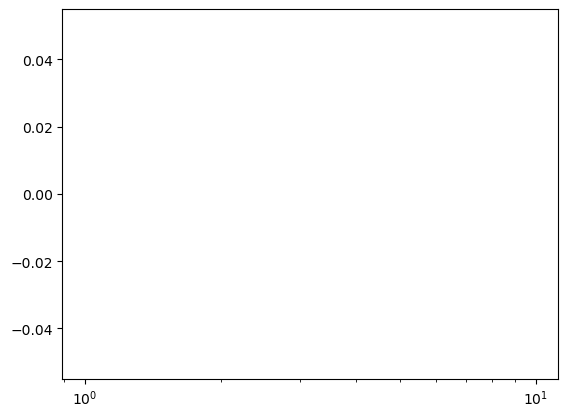

In [140]:
plt.plot(r_0,s)
plt.semilogx()